# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## <a id="to_the_begining">Оглавление</a>

1. **[Открытие данных](#start)**
    * [Описание данных](#describe_start)
    * [Вывод](#start_summary)
    
    
2. **[Предобработка данных](#step2)**
    * [Обработка пропущенных значений](#step2.1)
        * [Пропуске в столбце 'is_apartment'](#is_apartment)
        * [Пропуске в столбце 'balcony'](#balcony)
        * [Пропуске в столбце 'floors_total'](#floors_total)
        * [Пропуске в столбце 'ceiling_height'](#ceiling_height)
        * [Пропуске в столбце 'locality_name'](#locality_name)
        * [Пропуски в столбцах 'living_area' и 'kitchen_area'](#areas)
        * [Пропуске в остальных столбцах](#other)
    * [Обработка дубликатов](#duplicates)
    * [Изменение типов данных](#data_types)
    
    
3. **[Расчет и добавление в таблицу параметров](#step3)**
    * [Стоимость одного квадратного метра](#price_by_meter)
    * [День недели, месяц и год публикации](#date_data)
    * [Категоризация данных по этажу квартиры](#floor_type)
    * [Индексы площади кухни и жилой площади](#areas_new)
    * [Проверка результатов](#check_result)
    
    
4. **[Проведение исследовательского анализа данных](#step4)**    
    * [Изучение влияния отдельных параметров на цену](#influence)
    * [Изучение редких и выбивающихся значений](#rare)
    * [Выводы о влиянии различных факторов](#summary_influence)
    * [10 населенных пунктов с наибольшим количеством объявлений](#top10)
    * [Определение границ понятия "центр города"](#center)
    * [Анализ сегмента квартир в центре города](#center_analis)


5. **[Общий вывод](#step5)**  

   **[Чек-лист готовности проекта](#check_list)**  

### <a id="start"> Шаг 1. Откроем файл с данными и изучим общую информацию </a>

In [1]:
#в отдельной ячейке в самом начале работы импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
import warnings

In [2]:
pd.options.display.max_columns = None
estate = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\praktikum-to-git\\03_real_estate_data.csv', sep='\t') #в нашем случае записи
#разделены не запятыми, а табуляцией, поэтому указываем значение параметра sep, равное \t
estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
#выведем на экран информацию о полученном дата-сете
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
estate.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


### <a id="describe_start">Описание данных</a>

    • airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
    • balcony — число балконов
    • ceiling_height — высота потолков (м)
    • city_сenters_nearest — расстояние до центра города (м)
    • days_exposition — сколько дней было размещено объявление (от публикации до снятия)
    • first_day_exposition — дата публикации
    • floor — этаж
    • floors_total — всего этажей в доме
    • is_apartment — апартаменты (булев тип)
    • kitchen_area — площадь кухни в квадратных метрах (м²)
    • last_price — цена на момент снятия с публикации
    • living_area — жилая площадь в квадратных метрах(м²)
    • locality_name — название населённого пункта
    • open_plan — свободная планировка (булев тип)
    • parks_around3000 — число парков в радиусе 3 км
    • parks_nearest — расстояние до ближайшего парка (м)
    • ponds_around3000 — число водоёмов в радиусе 3 км
    • ponds_nearest — расстояние до ближайшего водоёма (м)
    • rooms — число комнат
    • studio — квартира-студия (булев тип)
    • total_area — площадь квартиры в квадратных метрах (м²)
    • total_images — число фотографий квартиры в объявлении

### <a id="start_summary">Вывод</a>

Полученная нами таблица содержит 23699 записей (строк) и 22 параметра (столбца). Из них всего 8 не содержат пропусков. В столбце `'cityCenters_nearest'` присутствует заглавная буква, что нарушает единообразие названий столбцов.
Также наблюдаются несоответствия в типах данных: вместо 3 параметров, принимающих булевы значения, в нашей таблице только 2 столбца имеют корректный тип; столбцы, содержащие данные о количестве этажей в доме, количестве балконов и количестве парков и водоемов в радиусе 3 км., имеют тип float, тогда как параметр может принимать только целочисленные значения.

<div class="alert alert-block alert-info">
   Что касается пропусков, данные о высоте потолков, количестве этажей в здании, жилой площади и площади кухни, количестве балконов и принадлежности жилья к классу аппартаментов - указываются лицом, размещающим объявление. Часть пропусков имеют случайный характер, другая часть может нести определенную информацию. Так, количество балконов могли пропустить респонденты, размещающие объявления на продажу квартир, не имеющих балконов. А информация о принадлежности жилья к классу аппартаментов могла быть опущена намеренно с целью "попасть" в ценовой сегмент полноценного жилья. С другой стороны, пропустить этот параметр могли так же, как в случае с балконами, респонденты, квартиры которых не относятся к аппартаментам.

Часть значений заполнялась автоматически, программным способом: дата размещения объявления и количество дней до снятия, число фотографий в объявлении, количество в радиусе 3 км. и расстояние до ближайших парков и водоемов. Пропуски в столбце "количество дней до снятия объявления с публикации" могут быть обусловлены тем, что объявление до сих пор (на момент выгрузки данных) не снято с публикации. Пропуски в расстояниях могут быть связаны с некооректной работой алгоритма определения расстояния или с некорректным вводом данных адреса пользователями. Если программа не может четко инициализировать расположение дома, в котором находится квартира к продаже, логично, что она не сможет и рассчитать расстояние до ближайших парков и водоемов.
    </div> 

###### [↑ к оглавлению ↑](#to_the_begining)

### <a id="step2">Шаг 2. Предобработка данных</a>

Сперва приведем к единообразию названия столбцов таблицы:

In [5]:
estate.rename(columns=lambda x: 
              x.replace('cityCenters_nearest', 'city_centers_nearest'), inplace=True)

### <a id="step2.1">2.1. Обработка пропусков</a>

Посчитаем количество пропусков в данных:

In [6]:
print(estate.isna().sum().sum())
estate.isna().sum()

101441


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Всего в таблице 101441 пропуск, больше всего пропусков в столбце, указывающем на принадлежность жилья к классу аппартаментов, на втором месте столбцы "расстояние до ближайшего парка" и "расстояние до ближайшего водоема", третья позиция у показателей "количество балконов" и "высота потолков".

### <a id="is_apartment">2.1.1. Пропуске в столбце 'is_apartment'</a>

In [7]:
estate['is_apartment'].value_counts() #запросим веса уникальных значений параметра 'is_apartment'

False    2725
True       50
Name: is_apartment, dtype: int64

Видим, что столбец 'is_apartment' фактически состоит из пропусков, за редкими исключениями (заполнено менее 12% данных по столбцу).
Апартаменты отличаются от жилых квартир только юридически и стоимостью за квадратный метр при прочих равгных условиях, т.е. на основании имеющихся в нашем распоряжении данных не представляется возможным заполнить пропуски исходя из доступной информации.
По данным сервиса "Яндекс.Недвижимость" от 08.12.2020 г. для произвольно выбранной области карты, охватывающей Санкт-Петербург и Ленинградскую область, по фильтру "без апартаментов" на выходе 36298 вариантов, по фильтру "только апартаменты" - 2928 вариантов. Т.о. можно говорить о том, что соотношение апартаментов и не-апартаментов в продаже составляет приблизительно 8 к 100.

In [8]:
ap = 2928 / 36298
print('Отношение количества апартаментов в продаже к количеству жилой \
недвижимости составляет: {:.3f}'.format(ap))
print('В изучаемой выборке данных приблизительно {:.0f} апартаментов \
и {:.0f} жилых помещений.'.format(ap * estate.shape[0], estate.shape[0] - ap * estate.shape[0]))

Отношение количества апартаментов в продаже к количеству жилой недвижимости составляет: 0.081
В изучаемой выборке данных приблизительно 1912 апартаментов и 21787 жилых помещений.


Таким образом, мы получили приблизительное распределение в изучаемой выборке данных по параметру "является апартаментами / не является апартаментами", однако не можем достоверно заполнить пропуски на основании этих данных.

### <a id="balcony">2.1.2. Пропуски в столбце 'balcony'</a>

In [9]:
estate['balcony'].value_counts() #запросим веса уникальных значений параметра 'balcony'

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

В столбце, содержащем информацию о количестве балконов, содержится 11519 пропусков. Из таблицы выше видно, что записей с 1 балконом больше, чем записей с количеством балконов, равным 0. Логично предположить, что квартир без балконов в целом больше, чем квартир с каким-либо количеством балконов, а также что при заполнении данных о квартире и отсутствии балкона поле "количество балконов" могло было быть пропущено.
Заменим пропущенные значения на "0": 

In [10]:
#аргументом inplace заменим значения в исходном датафрейме
estate['balcony'].fillna(0, inplace=True)
#выведем на экран количество пропусков в столбце после заполнения
estate['balcony'].isna().sum()

0

### <a id="floors_total">2.1.3. Пропуски в столбце 'floors_total'</a>

In [11]:
estate['floors_total'].value_counts()

5.0     5788
9.0     3761
16.0    1376
12.0    1362
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     833
3.0      668
7.0      592
14.0     553
18.0     505
24.0     469
8.0      390
2.0      383
15.0     365
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
1.0       25
35.0      24
28.0      21
36.0       3
29.0       1
60.0       1
33.0       1
52.0       1
37.0       1
34.0       1
Name: floors_total, dtype: int64

Больше всего 5- и 9-этапжек, что выглядит похожим на правду (массовая типовая застройка), зданий, имеющих всего 1 этаж и количество этажей, близкое к 30 - меньше всего.

Самым высоким жилым зданием в Санкт-Петербурге с 2012 года по настоящее время является <a href ="https://ru.wikipedia.org/wiki/%D0%9A%D0%BD%D1%8F%D0%B7%D1%8C_%D0%90%D0%BB%D0%B5%D0%BA%D1%81%D0%B0%D0%BD%D0%B4%D1%80_%D0%9D%D0%B5%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_(%D0%B6%D0%B8%D0%BB%D0%BE%D0%B9_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BB%D0%B5%D0%BA%D1%81)">ЖК «Князь Александр Невский»</a>, который включает в себя 37 этажей. Следовательно, значения "52" и "60" можно считать ошибочными. Наиболее вероятно, что реальная этажность для указанных строк составляет "5" и "6" этажей соответственно. Исправим ошибочные значения:

In [12]:
estate['floors_total'].replace(60, 6)
estate['floors_total'].replace(52, 5)

0        16.0
1        11.0
2         5.0
3        14.0
4        14.0
         ... 
23694     5.0
23695     5.0
23696     3.0
23697    17.0
23698     5.0
Name: floors_total, Length: 23699, dtype: float64

Заполнить пропуски без дальнейшего искажения результатов также не представляется возможным, однако мы имеем всего 86 пропусков из 23699 строк данных, т.е. чуть более 0,36% от общего количества записей, и можем пожертвовать строками с пропусками:

In [13]:
estate['floors_total'].dropna(inplace=True)
estate['floors_total'].isna().sum()

0

### <a id="ceiling_height">2.1.4. Пропуски в столбце 'ceiling_height'</a>

In [14]:
#запросим уникальные значения для столбца 'ceiling_height'
estate['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Как мы можем увидеть, помимо пропусков в столбце есть аномальные значения - квартиры с высотой потолков больше 8 метров и меньше 2. Также имеются значения с ошибочно проставленным порядком (например, вместо 2.75 - 27.5).
Сначала разберемся с некорректными значениями порядка:

In [15]:
estate['ceiling_height'].replace(26., 2.6)
estate['ceiling_height'].replace(24., 2.4)
estate['ceiling_height'].replace(2., 2.5)
estate['ceiling_height'].replace(27., 2.7)
estate['ceiling_height'].replace(27.5, 2.75)
estate['ceiling_height'].replace(32., 3.2)


0        2.70
1         NaN
2         NaN
3         NaN
4        3.03
         ... 
23694    3.70
23695     NaN
23696     NaN
23697    3.00
23698    2.50
Name: ceiling_height, Length: 23699, dtype: float64

Предположим, высота потолков в двухэтажных квартирах, пентхаусах или мансардах может достигать 8 метров (по 4 метра на этаж), но вряд ли больше этой величины. Также потолки в квартире вряд ли могут быть менее 2 метров, и тем более 1 метр или 1 метр 20 сантиметров. А если и так, это исключительные случаи, которые не вписываются в общую картину, и за счет их малого количества, можно пожертвовать этими записями.

In [16]:
estate.query('ceiling_height > 8 or ceiling_height <=2').sort_values(by='ceiling_height')


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22590,16,6000000.0,55.00,2018-10-31T00:00:00,2,1.00,12.0,32.4,7,NaN,False,False,10.00,0.0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0
5712,5,1500000.0,42.80,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,NaN,False,False,5.20,0.0,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000.0,40.00,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,NaN,False,False,8.34,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
11352,4,3300000.0,36.00,2017-06-18T00:00:00,1,2.00,17.0,15.2,12,NaN,False,False,10.10,0.0,посёлок Металлострой,25268.0,26980.0,0.0,NaN,0.0,NaN,53.0
16884,0,1500000.0,33.00,2018-10-03T00:00:00,1,2.00,5.0,20.0,5,False,False,False,6.00,0.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,6.0
5850,9,1650000.0,35.50,2018-05-29T00:00:00,1,2.00,5.0,NaN,5,NaN,False,False,NaN,0.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,100.0
19098,7,2700000.0,56.00,2018-02-04T00:00:00,3,2.00,5.0,46.0,1,NaN,False,False,6.00,0.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,282.0
16446,6,12300000.0,88.30,2019-03-12T00:00:00,3,2.00,5.0,63.9,2,NaN,False,False,12.00,0.0,Санкт-Петербург,38415.0,7675.0,1.0,568.0,1.0,154.0,NaN
19329,5,1700000.0,40.00,2018-07-15T00:00:00,2,2.00,9.0,NaN,8,NaN,False,False,NaN,0.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0
22960,17,2300000.0,53.60,2018-10-18T00:00:00,2,2.00,2.0,19.0,1,NaN,False,False,10.00,0.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Особого внимания заслуживает запись под номером 22869: стоимость 15 миллионов, высота потолков - 100 метров (около 33 этажей) при общем количестве этажей в здании 5, общая площадь - 25 квадратных метров, и полное отсутствие фотографий. Больше похоже на искажение в данных, чем на реальное объявление о продаже.

In [17]:
estate = estate.drop([22590, 5712, 16934, 5863, 22309, 15061, 17496, 22869])


В данном подпункте мы заменили ошибочные значения высоты потолков там, где это было возможно и избавились от записей, для которых невозможно было подобрать корректную величину.
Мы решили полностью удалить строки, а не избавиться только от некорректных данных, поскольку строк для удаления было незначительное количество, и их отсутствие не должно в сколько-нибудь значительной степени сказаться на итоговых данных. 

<a id="ceiling"><font color="black">Следующим шагом заполним пропуски в столбце "высота потолков". Для этого сперва вызовем математическое описание столбца:</font></a>

In [18]:
estate['ceiling_height'].describe()

count    14496.000000
mean         2.762229
std          0.950378
min          2.000000
25%          2.520000
50%          2.650000
75%          2.800000
max         32.000000
Name: ceiling_height, dtype: float64

<div class="alert alert-block alert-info">
Как мы видим, среднее значение высоты потолка по выборке составляет 2.72 метра, медианное значение - 2.65 метра.
Обратимся к <a href = "http://docs.cntd.ru/document/1200035248">СНиП 31-01-2003 "Здания жилые многоквартирные"</a>: согласно пункту 5.8. для климатических зон, к которым относится Санкт-Петербург, высота потолков должна быть не менее 2.5 метров.
На основании полученной информации выберем для заполнения пропусков стандарт высоты потолков для Санкт-Петербурга, равный 2.7 метра (значение находится в интервале между средним значением и медианой, и удовлетворяет всем условиям).
</div>

In [19]:
estate['ceiling_height'] = estate['ceiling_height'].fillna(2.7)

### <a id="locality_name">2.1.5. Пропуски в столбце 'locality_name'</a>

Разберемся с пропусками в столбце "locality_name". Для начала вызовем уникальные значения для этого столбца:

In [20]:
estate['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Можем обратить внимание на появление дубликатов в связи с использованием буквы "ё" вместо "е", исправим ситуацию:

In [21]:
estate['locality_name'] = estate['locality_name'].str.replace('ё', 'е')

#а также приведем к единообразию наименования населенных пунктов
estate['locality_name'] = estate['locality_name'].str.replace('городского', '')
estate['locality_name'] = estate['locality_name'].str.replace('типа', '')
estate['locality_name'] = estate['locality_name'].str.replace('имени', '')
estate['locality_name'] = estate['locality_name'].str.replace('городской', '')
estate['locality_name'] = estate['locality_name'].str.replace(' поселок', 'поселок')
estate['locality_name'] = estate['locality_name'].str.replace('коттеджныйпоселок', 'поселок')


Пропусков в данных не слишком много, всего 49 записей не содержат информации о населенном пункте. Заполнить мы их не можем, поэтому оставим "как есть".

### <a id="areas">2.1.6. Пропуски в столбцах 'living_area' и 'kitchen_area'</a>

Для заполнения пропусков в значениях жилой площади квартиры и площади хухни сначала добавим в нашу таблицу столбцы, в которых будут отображены отношения жилой площади и площади кухни к общей площади квартиры для каждой записи, для которой возможно сделать рассчет.
Далее рассчитаем индексы жилой площади и площади кухни как медиану по полученным столбцам.
Заполним пропуски значениями, равными произведению общей площади (к счастью, в этом столбце у нас нет пропусков) на соответствующий индекс.

<div class="alert alert-block alert-info">
Сперва выясним степень зависимости площади кухни и жилой площади от общей площади квартиры, для этого рассчитаем соответствующие коэффициенты корреляции:
</div>

In [22]:
print('Коэффициент корреляции, отражающий зависимость площади кухни от общей площади\
 квартиры,\nсоставляет {:.2f}.'.format(estate['kitchen_area'].corr(estate['total_area'])))

Коэффициент корреляции, отражающий зависимость площади кухни от общей площади квартиры,
составляет 0.61.


In [23]:
print('Коэффициент корреляции, отражающий зависимость жилой площади от общей площади\
 квартиры,\nсоставляет {:.2f}.'.format(estate['living_area'].corr(estate['total_area'])))

Коэффициент корреляции, отражающий зависимость жилой площади от общей площади квартиры,
составляет 0.94.


<div class="alert alert-block alert-info">
В отношении зависимости жилой площади от общей площади квартиры у нас не остается вопросов, коэффицент равен 0.94, корреляция близка к абсолютной. Что касается площади кухни, здесь зависимость не столь ярко выраженная, коэффициент составляет 0.61 (чем больше общая площадь, тем больше жилая площадь, но тем больше может быть и площадь коридоров и санузлов, которые не относятся ни к жилой площади, ни к площади кухни). 
    Поскольку мы не учитываем площадь санузла, коридоров и технических помещений, и коэффициент корреляции достаточно высок, можем для заполнения пропусков в значениях площади кухни использовать тот же метод, что и для жилой площади, выбранный и описанный нами выше.
</div>

In [24]:
#создадим столбец с долей площади кухни в общей площади
estate['kitchen_area_index'] = estate['kitchen_area'] / estate['total_area']
#рассчитаем индекс площади кухни
kitchen_area_index = estate['kitchen_area_index'].median() 
#рассчитываем медианой во избежание искажений из-за предельных значений
kitchen_area_index

0.1724137931034483

In [25]:
#заполним пропуски в столбце с данными о площади кухни произведением общей площади квартиры 
#и индекса площади кухни
estate['kitchen_area'].fillna(estate['total_area'] * kitchen_area_index, inplace=True)

In [26]:
#аналогично площади кухни заполним пропуски для жилой площади
estate['living_area_index'] = estate['living_area'] / estate['total_area']

living_area_index = estate['living_area_index'].median()
living_area_index

0.5678598992678503

In [27]:
estate['living_area'].fillna(estate['total_area'] * living_area_index, inplace=True)

### <a id="other">2.1.7. Пропуски в остальных столбцах</a>

По остальным столбцам достоверно заполнить пропуски не представляется возможным. Невозможно автоматизировать заполнение данных по количеству водоемов и парков в радиусе 3 километров и по расстоянию до ближайших водоема и парка без серьезной работы с координатами жилья и подробной картографической базой. Вручную же заполнять пропуски в таких количествах также невозможно.

Несколько иначе обстоит ситуация с расстоянием до аэропорта и до центра города, однако имеющихся в нашем распоряжении данных должно хватить для анализа, а заполнение пропусков средними значениями (и даже средними значениями по категориям город/область) может повлиять на чистоту данных.

###### [↑ к оглавлению ↑](#to_the_begining)

### <a id="duplicates">2.2. Поиск дубликатов</a>

In [28]:
estate.duplicated().sum()

0

В нашей таблице нет дубликатов, только уникальные данные.

### <a id="data_types">2.3. Изменение типов данных</a>

Запросим еще раз информацию о датафрейме:

In [29]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23691 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23691 non-null  int64  
 1   last_price            23691 non-null  float64
 2   total_area            23691 non-null  float64
 3   first_day_exposition  23691 non-null  object 
 4   rooms                 23691 non-null  int64  
 5   ceiling_height        23691 non-null  float64
 6   floors_total          23605 non-null  float64
 7   living_area           23691 non-null  float64
 8   floor                 23691 non-null  int64  
 9   is_apartment          2774 non-null   object 
 10  studio                23691 non-null  bool   
 11  open_plan             23691 non-null  bool   
 12  kitchen_area          23691 non-null  float64
 13  balcony               23691 non-null  float64
 14  locality_name         23642 non-null  object 
 15  airports_nearest   

In [30]:
#изменение типа float на тип int
estate['total_images'] = estate['total_images'].astype('int')
estate['last_price'] = estate['last_price'].astype('int')
estate['rooms'] = estate['rooms'].astype('int')
estate['balcony'] = estate['balcony'].astype('int')

#изменение типа object на тип bool
estate['is_apartment'] = estate['floors_total'].astype('bool')
estate['studio'] = estate['studio'].astype('bool')
estate['open_plan'] = estate['open_plan'].astype('bool')

#изменение типа object на тип date
estate['first_day_exposition'] = pd.to_datetime(estate['first_day_exposition'], 
                                                format='%Y.%m.%d')


Выведем на экран результат изменения типов данных по столбцам:

In [31]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23691 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23691 non-null  int32         
 1   last_price            23691 non-null  int32         
 2   total_area            23691 non-null  float64       
 3   first_day_exposition  23691 non-null  datetime64[ns]
 4   rooms                 23691 non-null  int32         
 5   ceiling_height        23691 non-null  float64       
 6   floors_total          23605 non-null  float64       
 7   living_area           23691 non-null  float64       
 8   floor                 23691 non-null  int64         
 9   is_apartment          23691 non-null  bool          
 10  studio                23691 non-null  bool          
 11  open_plan             23691 non-null  bool          
 12  kitchen_area          23691 non-null  float64       
 13  balcony         

In [32]:
#проверим формат отображения даты размещения объявления
estate['first_day_exposition'].head(1)

0   2019-03-07
Name: first_day_exposition, dtype: datetime64[ns]

###### [↑ к оглавлению ↑](#to_the_begining)

### <a id="step3">Шаг 3. Расчет и добавление в таблицу параметров</a>

### <a id="price_by_meter">3.1. Стоимость одного квадратного метра</a>

Добавим в таблицу столбец 'price_by_meter', в котором рассчитаем цену за квадратный метр как частное от деления стоимости квартиры на общую площадь квартиры.

In [33]:
estate['price_by_meter'] = estate['last_price'] / estate['total_area']

### <a id="date_data">3.2. День недели, месяц и год публикации</a>

Добавим столбцы 'day_of_week', 'month' и 'year' в которых поместим день недели, месяц и год публикации объявления соответственно:

In [35]:
estate['day_of_week'] = estate['first_day_exposition'].dt.weekday
estate['month'] = estate['first_day_exposition'].dt.month
estate['year'] = estate['first_day_exposition'].dt.year

### <a id="floor_type">3.3. Категоризация данных по этажу квартиры</a>

Добавим столбец 'floor_type' с категоризацией квартир по этажу, на котором они расположены:

In [36]:
f1 = (estate['floor'] == 1)
f2 = (estate['floor'] == estate['floors_total'])
estate['floor_type'] = np.select([f1, f2], ['первый', 'последний'], 
                           default='другой')

In [37]:
#проверим результаты категоризации по этажу
estate['floor_type'].value_counts()

другой       17440
последний     3335
первый        2916
Name: floor_type, dtype: int64

### <a id="areas_new">3.4. Индексы площади кухни и жилой площади</a>

Мы уже добавили к нашей таблице столбцы со значениями соотношений площади кухни к общей площади квартиры и жилой площади к общей площади квартиры при заполнении пропусков.
Пересчитаем эти показатели по новым данным без пропусков, чтобы также избавиться от пропусков и в них:

In [38]:
estate['kitchen_area_index'] = estate['kitchen_area'] / estate['total_area']
estate['living_area_index'] = estate['living_area'] / estate['total_area']

### <a id="check_result">3.5. Проверка результатов</a>

Проверим результат добавления столбцов. Распечатем первые 5 строк измененной таблицы:

In [39]:
estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_area_index,living_area_index,price_by_meter,day_of_week,month,year,floor_type
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.000000,8,True,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.231481,0.472222,120370.370370,3,3,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.70,11.0,18.600000,1,True,False,False,11.000000,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.272277,0.460396,82920.792079,1,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.70,5.0,34.300000,4,True,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.148214,0.612500,92785.714286,3,8,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.70,14.0,90.289724,9,True,False,False,27.413793,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,0.172414,0.567860,408176.100629,4,7,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.000000,13,True,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.410000,0.320000,100000.000000,1,6,2018,другой


###### [↑ к оглавлению ↑](#to_the_begining)

### <a id="step4">Шаг 4. Проведение исследовательского анализа данных</a>

### <a id="influence">4.1. Изучение влияния отдельных параметров на цену</a>

Изучим такие параметры, как общая площадь квартиры, цена продажи, количество комнат и высота потолков.

<div class="alert alert-block alert-info">
Для этого сперва запрсим математическое описание интересующих нас столбцов, после чего с помощью цикла построим гистограммы распределения для всех интересующих нас параметров:
</div>

In [40]:
estate.pivot_table(columns=['total_area', 'last_price', 'rooms', 'ceiling_height']).describe()

count    4.322040e+05
mean     6.879314e+03
std      2.534832e+04
min      0.000000e+00
25%      5.191638e-01
50%      5.000000e+00
75%      6.000000e+01
max      1.907500e+06
dtype: float64

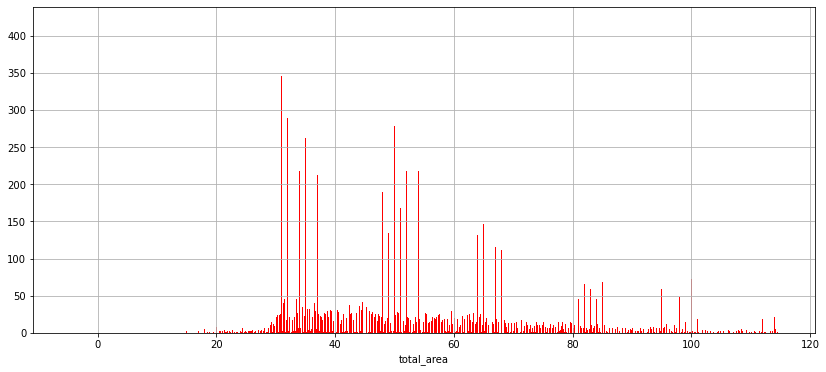

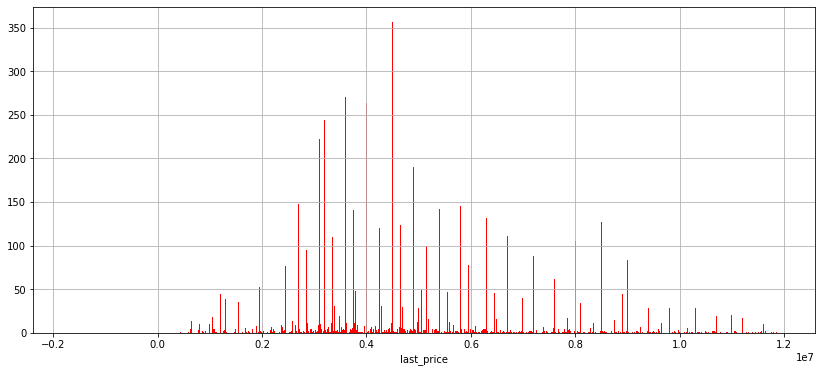

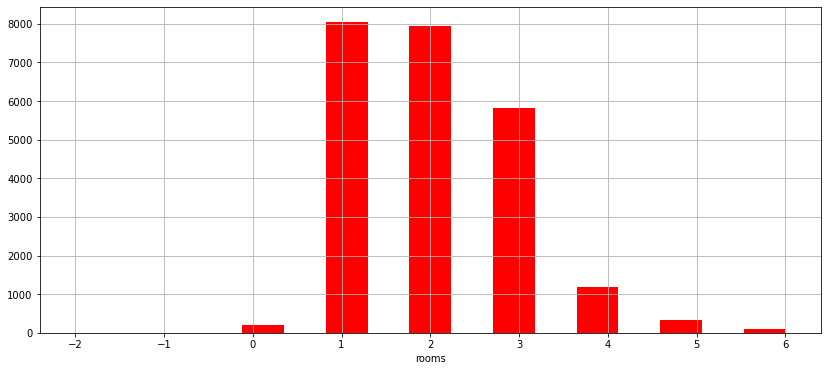

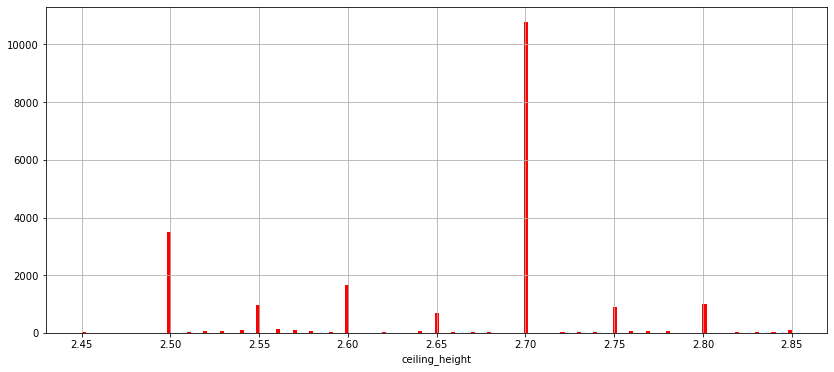

In [41]:
param_list = ['total_area', 'last_price', 'rooms', 'ceiling_height']
for param in param_list:
    estate[param].hist(bins = len(estate[param].unique()), 
                       figsize = (14, 6), color='red',
                       range=((estate[param].quantile(0.25) - 1.5 * (estate[param].quantile(0.75) - estate[param].quantile(0.25))),
                              estate[param].quantile(0.75) + 1.5 * (estate[param].quantile(0.75) - estate[param].quantile(0.25)))).set_xlabel(param)
    plt.show()

Медиана показателя `'total_area'` составляет 52 квадратных метра, среднее значение при этом - 60. Значит, в выборке имеем смещение влево за счет записей с исключительно большими значениями параметра "площадь". В диапазон от первой до третьей квартили попадают значения от 40 до примерно 70 метров (что весьма похоже на правду). От 70 до 100 квадратных метров количество значительно сокращается, от 100 до 125 сокращение становится менее явным, и квартиры с площадью более 125 метров имеют характер скорее единичных случаев.

Вполне логично больше всего 1- и 2-комнатных квартир, меньше 3-комнатных, и далее каждое новое приращение соответствует значительному снижению количества записей.
И медиана, и среднее значение находятся на уровне 2 комнат.

Средняя высота потолков составляет 2.72 м., медианное значение - 2.65. Редкие случаи высоты потолков, превышающей 3,5 метра могут относиться к двухэтажным квартирам или иным квартирам, конструктивная особенность которых подразумевает большую высоту потолков.

In [42]:
estate['days_exposition'].describe()

count    20511.000000
mean       180.910585
std        219.752298
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

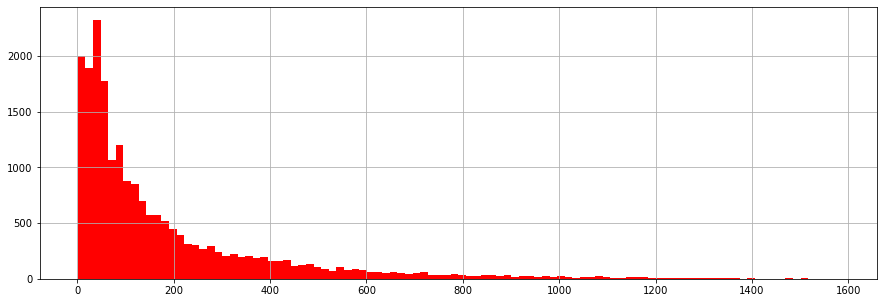

In [43]:
estate['days_exposition'].hist(bins = 100, figsize = (15, 5), color='red')

В среднем квартиры продаются за полгода (по медиане - за 3 месяца). Самая быстрая продажа была совершена всего за 1 день, большая часть квартир продается в течение 8 месяцев, однако отдельные варианты достигают показателей от 2 до 5 лет.

### <a id="rare">4.2. Изучение редких и выбивающихся значений</a>

In [44]:
estate.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_area_index,living_area_index,price_by_meter,day_of_week,month,year
count,23691.000000,2.369100e+04,23691.000000,23691.000000,23691.000000,23605.000000,23691.000000,23691.000000,23691.000000,23691.000000,18150.000000,18173.000000,18174.000000,8075.000000,18174.000000,9105.000000,20511.000000,23691.000000,23691.000000,2.369100e+04,23691.000000,23691.000000,23691.000000
mean,9.857583,6.541654e+06,60.352057,2.070786,2.738076,10.672400,34.580954,5.891562,10.491947,0.590731,28795.560716,14191.552633,0.611313,490.809536,0.769946,518.104778,180.910585,0.185914,0.565030,9.940199e+04,2.569457,6.399772,2017.367017
std,5.681639,1.088864e+07,35.658003,1.078480,0.744019,6.595368,22.342809,4.885029,6.029864,0.958526,12631.541955,8609.750070,0.802047,342.341247,0.938110,277.698784,219.752298,0.069501,0.101051,5.020754e+04,1.789143,3.491791,1.039851
min,0.000000,1.219000e+04,12.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,0.025381,0.021583,1.118349e+02,0.000000,1.000000,2014.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000,0.136859,0.500000,7.658547e+04,1.000000,3.000000,2017.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,0.000000,26726.000000,13098.000000,0.000000,455.000000,1.000000,502.000000,95.000000,0.172414,0.567860,9.500000e+04,3.000000,6.000000,2017.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.100000,8.000000,12.000000,1.000000,37276.500000,16293.000000,1.000000,612.000000,1.000000,730.000000,232.000000,0.223738,0.631579,1.142504e+05,4.000000,10.000000,2018.000000
max,50.000000,7.630000e+08,900.000000,19.000000,32.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,0.787879,1.000000,1.907500e+06,6.000000,12.000000,2019.000000


Нас интересуют закономерности, поэтому необходимо исключить из данных сильно выбивающиеся из общей массы значения (выбросы).

In [45]:
estate['last_price'].sort_values().head(30)

8793      12190
14911    430000
17456    430000
16274    440000
16219    450000
9581     450000
17676    450000
5698     450000
18867    470000
21912    470000
23484    470000
16032    480000
10782    490000
6859     490000
2097     500000
14904    500000
4405     500000
14295    500000
22430    520000
12607    530000
1358     550000
7962     550000
7376     550000
11351    550000
13768    550000
1053     550000
8630     560000
22997    560000
19460    560000
13809    565000
Name: last_price, dtype: int32

<div class="alert alert-block alert-info">
Для этого построим график разброса типа "ящик с усами" для каждого интересующего нас параметра.
</div>

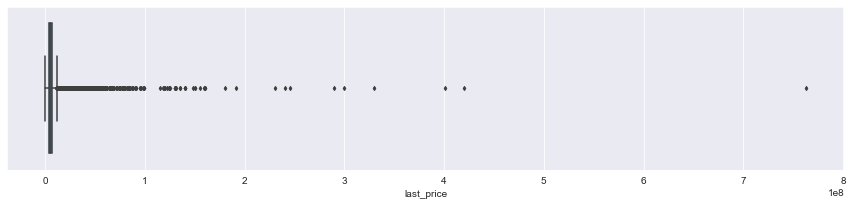

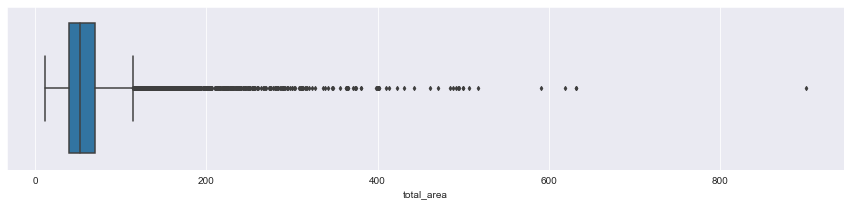

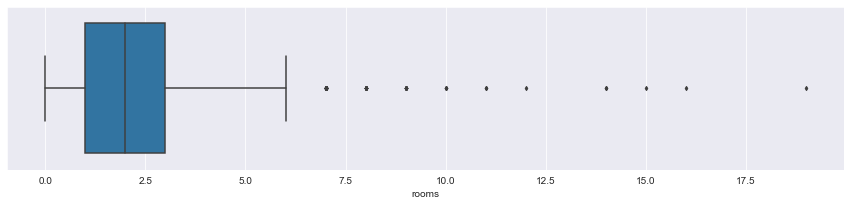

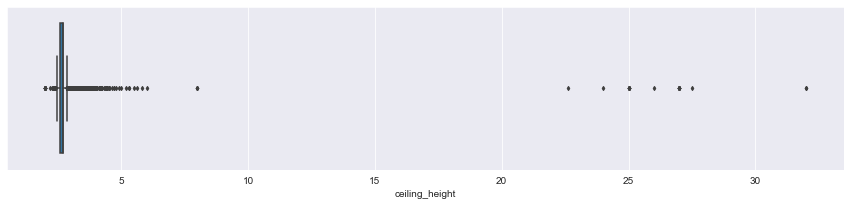

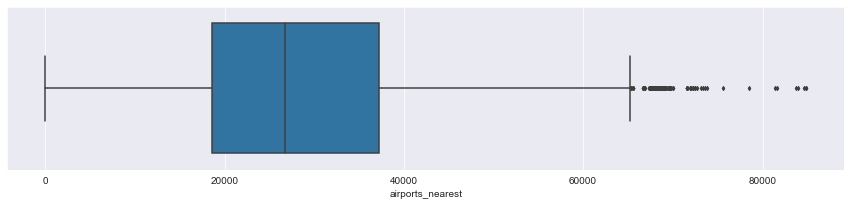

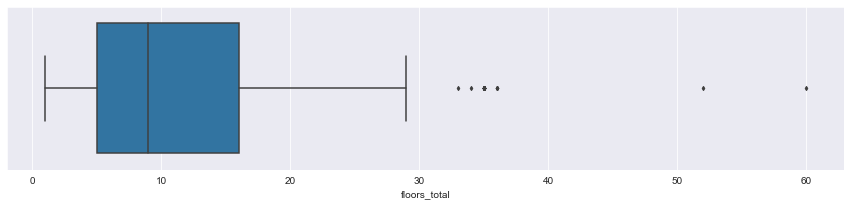

In [46]:
sns.set_style('darkgrid')
param_list1 = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'airports_nearest', 'floors_total']
for param in param_list1:
    plt.rcParams['figure.figsize']=(15, 3)
    sns.boxplot(x=param, data=estate, fliersize=3)
    plt.show()

In [47]:
def whisker(column):
    k = 1.5
    column_min = estate[column].quantile(0.25) - k * (estate[column].quantile(0.75) - estate[column].quantile(0.25))
    column_max = estate[column].quantile(0.75) + k * (estate[column].quantile(0.75) - estate[column].quantile(0.25))
    print('Нижняя граница "усов" для параметра', column, 'равна', column_min)
    print('Верхняя граница "усов" для параметра', column, 'равна', column_max)
    print()

In [48]:
for column in param_list1:
    whisker(column)

Нижняя граница "усов" для параметра last_price равна -1700000.0
Верхняя граница "усов" для параметра last_price равна 11900000.0

Нижняя граница "усов" для параметра total_area равна -4.8500000000000085
Верхняя граница "усов" для параметра total_area равна 114.75000000000001

Нижняя граница "усов" для параметра rooms равна -2.0
Верхняя граница "усов" для параметра rooms равна 6.0

Нижняя граница "усов" для параметра ceiling_height равна 2.45
Верхняя граница "усов" для параметра ceiling_height равна 2.8500000000000005

Нижняя граница "усов" для параметра airports_nearest равна -9452.25
Верхняя граница "усов" для параметра airports_nearest равна 65313.75

Нижняя граница "усов" для параметра floors_total равна -11.5
Верхняя граница "усов" для параметра floors_total равна 32.5



In [49]:
for param in param_list1:
    print(estate[param].describe())
    print()

count    2.369100e+04
mean     6.541654e+06
std      1.088864e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

count    23691.000000
mean        60.352057
std         35.658003
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

count    23691.000000
mean         2.070786
std          1.078480
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

count    23691.000000
mean         2.738076
std          0.744019
min          2.000000
25%          2.600000
50%          2.700000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64

count    18150.000000
mean     28795.560716
std      12631.541955
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37276.500000
max    

<div class="alert alert-block alert-info">
Определим границы величин, за рамками которых уже находятся выбросы:
    
<ul>
<li>для общей площади это значения от 5 до 115;</li>
<li>для количества комнат - от 0 до 6 (допускаем нулевое значение параметра "количество комнат" для квартир-студий);</li>
<li>для высоты потолков - от 2.45 до 2.85, однако мы заполнили пропуски значением 2.7,что могло вызвать искажение распределения, поэтому для высоты потолков отдельно вызовем график типа boxenplot;</li>
<li>для расстояния до аэропорта - от 0 до 65313 м.;</li>
<li>для общего количества этажей - от 1 до 32.</li>
</ul>
</div>

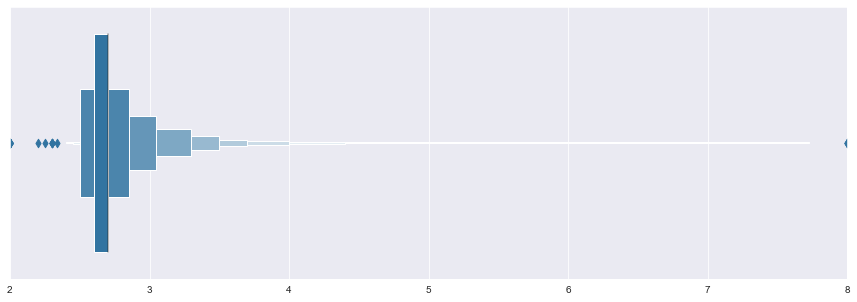

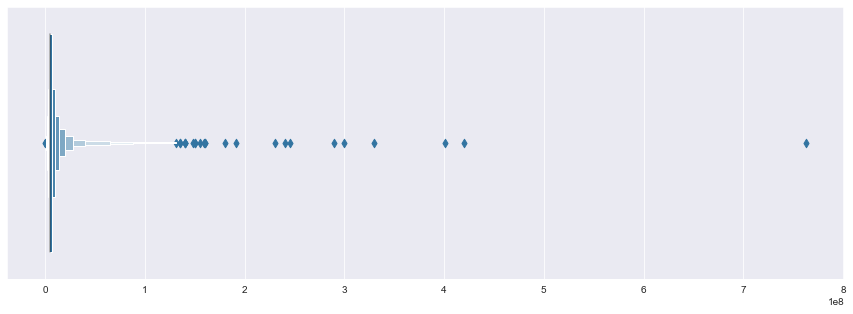

In [50]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.rcParams['figure.figsize']=(15,5)
    plt.xlim(2, 8)
    sns.boxenplot(x=['ceiling_height'], data=estate)
    plt.show()
    sns.boxenplot(x=['last_price'], data=estate)

<div class="alert alert-block alert-info">
По графику выше видно (верхний график), что нас устроит величина высоты потолков в диапазоне от 2.5 до 3.3 метров.
</div>

<div class="alert alert-block alert-info">Методы боксплот и боксенплот не дают наглядного достоверного результата по нижней и верхней границам параметра last_price, поэтому рассчитаем ее по нижнему 5% перцентилю: 1.87 млн. руб., сверху отбросим всего 1% наблюдений: 36 млн. руб.</div>

In [51]:
display(estate.quantile(0.05))
display(estate.quantile(0.99))

total_images            1.000000e+00
last_price              1.870000e+06
total_area              3.100000e+01
rooms                   1.000000e+00
ceiling_height          2.500000e+00
floors_total            4.000000e+00
living_area             1.530000e+01
floor                   1.000000e+00
is_apartment            1.000000e+00
studio                  0.000000e+00
open_plan               0.000000e+00
kitchen_area            5.300000e+00
balcony                 0.000000e+00
airports_nearest        1.155635e+04
city_centers_nearest    3.541000e+03
parks_around3000        0.000000e+00
parks_nearest           9.570000e+01
ponds_around3000        0.000000e+00
ponds_nearest           9.400000e+01
days_exposition         9.000000e+00
kitchen_area_index      1.000000e-01
living_area_index       3.953488e-01
price_by_meter          4.132194e+04
day_of_week             0.000000e+00
month                   1.000000e+00
year                    2.015000e+03
Name: 0.05, dtype: float64

total_images            2.000000e+01
last_price              3.600000e+07
total_area              1.972700e+02
rooms                   5.000000e+00
ceiling_height          3.600000e+00
floors_total            2.600000e+01
living_area             1.220000e+02
floor                   2.300000e+01
is_apartment            1.000000e+00
studio                  0.000000e+00
open_plan               0.000000e+00
kitchen_area            3.551000e+01
balcony                 5.000000e+00
airports_nearest        5.854748e+04
city_centers_nearest    5.006484e+04
parks_around3000        3.000000e+00
parks_nearest           2.102000e+03
ponds_around3000        3.000000e+00
ponds_nearest           1.159000e+03
days_exposition         1.068800e+03
kitchen_area_index      4.166667e-01
living_area_index       7.894963e-01
price_by_meter          2.666698e+05
day_of_week             6.000000e+00
month                   1.200000e+01
year                    2.019000e+03
Name: 0.99, dtype: float64

In [52]:
estate_clean = estate.query('last_price >= 1870000 and last_price <= 36000000 and \
total_area <= 115 and total_area >= 5 and rooms <= 6 and rooms >= 0 and airports_nearest >= 0 and \
airports_nearest <= 65313 and floors_total >= 1 and floors_total <= 32')

### <a id="summary_influence">4.3. Выводы о влиянии различных факторов</a>

In [53]:
estate_corr = estate_clean[['last_price', 'price_by_meter', 'total_area', 'rooms', 'city_centers_nearest',
                            'balcony', 'ceiling_height', 'floor', 'airports_nearest']].copy()
estate_corr.corr()

,last_price,price_by_meter,total_area,rooms,city_centers_nearest,balcony,ceiling_height,floor,airports_nearest
last_price,1.000000,0.687643,0.742084,0.435248,-0.351062,0.052422,0.122282,0.029422,-0.031402
price_by_meter,0.687643,1.000000,0.081690,-0.153659,-0.393591,0.029421,0.090011,0.099770,-0.033664
total_area,0.742084,0.081690,1.000000,0.783331,-0.185136,0.052987,0.101828,-0.027645,-0.020895
rooms,0.435248,-0.153659,0.783331,1.000000,-0.103947,-0.003068,0.039793,-0.169297,-0.049574
city_centers_nearest,-0.351062,-0.393591,-0.185136,-0.103947,1.000000,0.062996,-0.107773,0.015609,0.197908
balcony,0.052422,0.029421,0.052987,-0.003068,0.062996,1.000000,-0.008666,0.182092,0.048109
ceiling_height,0.122282,0.090011,0.101828,0.039793,-0.107773,-0.008666,1.000000,-0.022919,-0.032095
floor,0.029422,0.099770,-0.027645,-0.169297,0.015609,0.182092,-0.022919,1.000000,0.089798
airports_nearest,-0.031402,-0.033664,-0.020895,-0.049574,0.197908,0.048109,-0.032095,0.089798,1.000000


Из полученной таблицы корреляции видно, что самая сильная взаимосвязь наблюдается между количеством комнат и общей площадью, коэффициент корреляции составляет 0.78. Действительно, хотя бывают квартиры с одной, но большой комнатой, или при той же площади с тремя маленькими, в среднем чем больше комнат в квартире, тем больше ее площадь.

Что касается цены, можем наблюдать следущее: сильнее всего цена зависит от общей площади (что логично, поскольку стоимость квартиры рассчитывается в базе исходя из цены за квадратный метр). Коэффициент корреляции составляет 0.72, что является довольно большим показателем.

С количеством комнат цена также имеет положительную корреляцию, однако корреляцию весьма слабую, коэффициент - всего 0.41. И, скорее всего, в данном случае наблюдаем косвенную зависимость цены от площади через взаимосвязь площади и количества комнат.

Влияние таких характеристик как количество балконов, этаж, высота потолков и близость аэропорта настолько ничтожно малы, что их можно исключить из расчета.

Расстояние до центра города находится в отрицательной корреляции со стоимостью квартиры. Т.е. чем дальше от центра, тем стоимость ниже. И коэффициент корреляции в данном случае самый низкий, по модулю всего 0.34. Однако тут мы считаем по всем предложениям, посмотрим на коэффицент корреляции конкретно для города, без области:

In [54]:
estate_clean.query('locality_name == "Санкт-Петербург"')['last_price'].corr(
    estate['city_centers_nearest'])

-0.38946391878869013

Для Санкт-Петербурга коэффициент корреляции увеличился с -0.34 до -0.39.

<div class="alert alert-block alert-info">
Выведем на экран тепловую карту корреляции датасета estate_corr с помощью метода heatmap библиотеки seaborn.
Самые светлые и самые темные зоны показывают максимальную положительную и отрицательнуу соответственно корреляцию. Минимальные показатели корреляции соответствуют ячейкам цвета градиентной шкалы, близкой к нулевому значению.
</div>

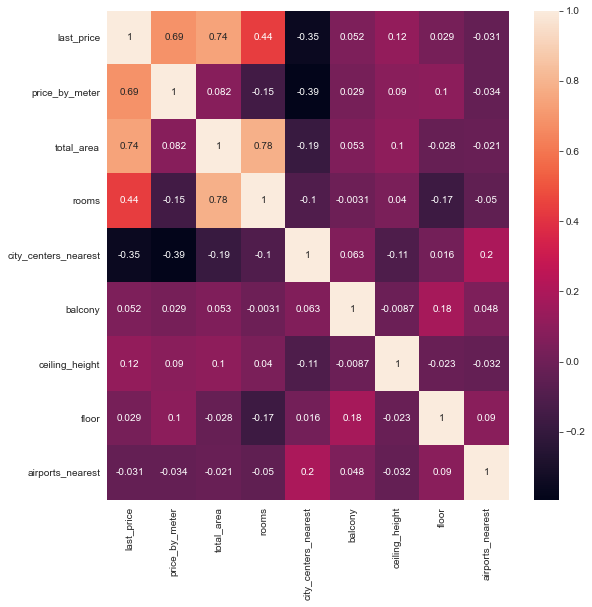

In [55]:
plt.rcParams['figure.figsize']=(9,9)
sns.heatmap(estate_corr.corr(), annot=True)

In [56]:
price_floor_mean = estate_clean.groupby('floor_type')['last_price'].mean()
price_floor_mean

floor_type
другой       6.167067e+06
первый       5.211706e+06
последний    5.927472e+06
Name: last_price, dtype: float64

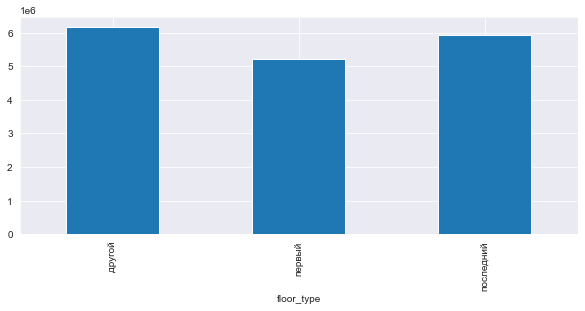

In [57]:
plt.rcParams['figure.figsize']=(10,4)
price_floor_mean.plot(kind='bar', grid=True)

Как видно из графика, самые дешевые квартиры располагаются на 1 этаже, и средняя стоимость таких квартир составляет около 5.1 млн., самые дорогие - "другие" этажи между первым и последним со средней стоимостью в 6.2 млн. Квартиры на последних этажах по цене расположились посередине, и соответствуют среднему значению 6.0 млн. Т.е. можно сформулировать два правила относительно этажности при определении стоимости: 1). любой этаж лучше (а значит, дороже), чем первый; и 2). люди предпочитают выбирать не крайние этажи (между первым и последним).

Изучим влияние дня недели, месяца и года размещения на стоимость квартиры:

In [58]:
estate_date = estate_clean[['last_price', 'day_of_week', 'month', 'year']].copy()
estate_date.head()

,last_price,day_of_week,month,year
0,13000000,3,3,2019
1,3350000,1,12,2018
2,5196000,3,8,2015
4,10000000,1,6,2018
6,3700000,3,11,2017


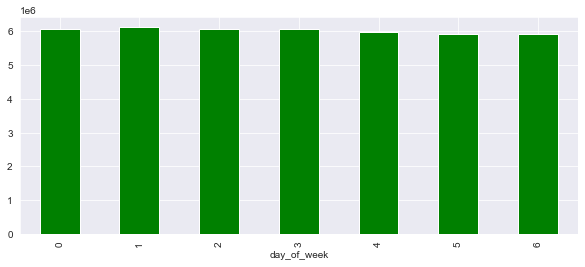

In [59]:
price_weekday = estate_date.groupby('day_of_week')['last_price'].mean().plot(kind='bar', 
                                                                             color='green', 
                                                                             grid=True)

Как мы видим, стоимость продажи абсолютно не зависит от дня недели, в который было размещено объявление. Заставило бы задуматься, если бы мы получили иные результаты.

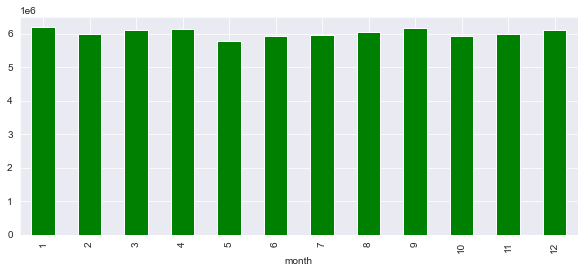

In [60]:
price_month = estate_date.groupby('month')['last_price'].mean().plot(kind='bar', 
                                                                     color='green',
                                                                     grid=True)

Схожая ситуация и с месяцем размещения объявления, средняя цена по месяцам варьируется в пределах от 5.8 млн. в мае до 6.5 млн. в январе, сентябре и декабре. Можно сделать вывод, что сезонность в некоторой степени все же влияет на стоимость квартир.

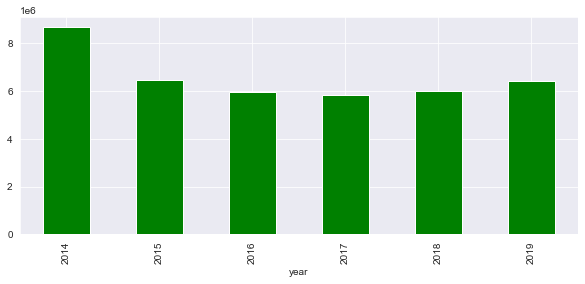

In [61]:
price_year = estate_date.groupby('year')['last_price'].mean().plot(kind='bar',
                                                                    color='green',
                                                                    grid=True)

По годам уже более отчетливо видна разница и динамика в изменении стоимости квартир. Самая высокая средняя цена наблюдалась в 2014 году, что можно связать с валютным кризисом в России 2014 - 2015 годов. В дальнейшем цена снизилась и установилась в районе показателя в 6 млн., а колебания от года к году объясняются общеэкономическими и внутренне-политическими показателями.

Как общий вывод анализа влияния времени размещения объявления на величину стоимости продажи можно заключить, что степень изменения цены находится в прямой зависимости с увеличением периода рассчета. Дни недели никак не влияют на цену, при рассмотрении по месяцам включаются сезонные особенности, и при рассмотрении временного интервала, равного одному году, наблюдаем уже влияние на цену макроэкономических глобальных факторов, связанных с экономикой страны в целом.

### <a id="top10">4.4. 10 населенных пунктов с наибольшим количеством объявлений</a>

In [62]:
top10 = (estate_clean.pivot_table(index='locality_name', values='price_by_meter',
                            aggfunc='count').sort_values(by='price_by_meter',
                                                         ascending=False)
         .iloc[:10])
top10

,price_by_meter
locality_name,
Санкт-Петербург,14404
поселок Шушары,431
Пушкин,348
Колпино,335
поселок Парголово,324
Петергоф,197
Красное Село,170
Сестрорецк,170
Ломоносов,125


In [63]:
top10_price = estate_clean.query('locality_name in @top10.index').pivot_table(
    index='locality_name', values='price_by_meter', aggfunc=['mean', 'max', 'min']).reset_index()
top10_price.columns = ['locality_name', 'mean_price_by_meter', 'max_price_by_meter', 'min_price_by_meter']
top10_price

,locality_name,mean_price_by_meter,max_price_by_meter,min_price_by_meter
0,Колпино,75347.651911,125000.000000,47957.371226
1,Красное Село,72332.103038,101714.285714,42500.000000
2,Ломоносов,73585.610659,100000.000000,52485.659656
3,Петергоф,84366.781722,225971.731449,51612.903226
4,Пушкин,102404.516759,256521.739130,59836.065574
5,Санкт-Петербург,110232.487653,848484.848485,26250.000000
6,Сестрорецк,102910.866763,182688.172043,50434.782609
7,поселок Металлострой,73853.150429,94311.377246,45977.011494
8,поселок Парголово,90540.966561,138522.427441,48405.466970
9,поселок Шушары,78548.667647,147826.086957,47700.416089


Выясним максимальное значение цены за квадратный метр для объявлений из топ-10 локаций по количеству объявлений:

In [64]:
int(top10_price['max_price_by_meter'].max())

848484

Аналогичным образом выясним минимальное значение:

In [65]:
int(top10_price['min_price_by_meter'].min())

26250

И среднее значение по всему топу:

In [66]:
int(top10_price['mean_price_by_meter'].mean())

86412

В нашем списке из 10 населенных пунктов с наибольшим количеством объявлений средняя цена за квадратный метр составляет 87155 рублей. Самый большой показатель приходится на населенный пункт Санкт-Петербург и составляет почти 850 тысяч (показатель, вполне реальный для самого дорогого элитного жилья), минимальный, что интересно, также в Санкт-Петербурге: чуть больше 37 тысяч рублей.
Если предположить, что "крайние" результаты нивелируют друг друга, средний показатель в 87 тысяч рублей выглядит весьма похожим на правду.
В качестве дополнительного вывода можно заключить, что в городе самая высокая дифференциация цен (и минимальный, и максимальный показатель пришлись на Санкт-Петербург).

<div class="alert alert-block alert-info">Построим график зависимости средней цены за квадратный метр от расположения:</div>

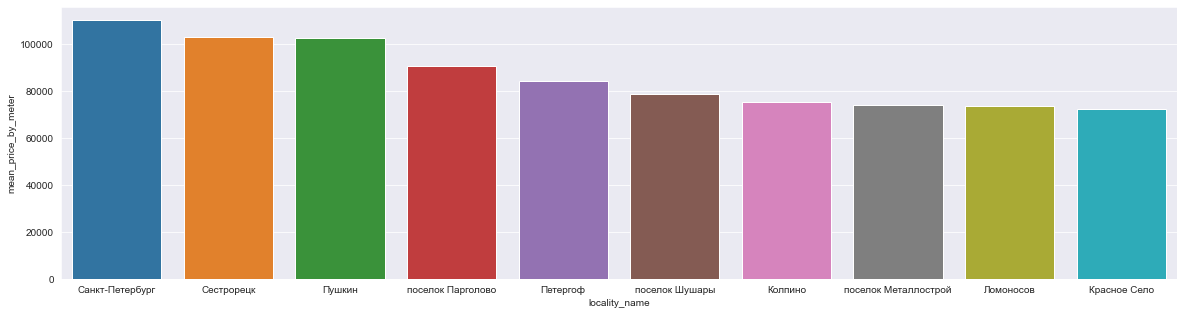

In [67]:
plt.rcParams['figure.figsize']=(20,5)
sns.barplot(x='locality_name', y='mean_price_by_meter', 
            data=top10_price.sort_values(by='mean_price_by_meter', ascending=False))
plt.show()

### <a id="center">4.5. Определение границ понятия "центр города"</a>

In [68]:
estate_city = estate_clean.query('locality_name == "Санкт-Петербург"')

In [69]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    estate_city['city_centers_nearest_round'] = estate_city['city_centers_nearest'].div(1000).astype(int)
    estate_city_km = estate_city.pivot_table(index = 'city_centers_nearest_round', 
                                         values = 'price_by_meter', 
                                         aggfunc=['mean', 'median'])

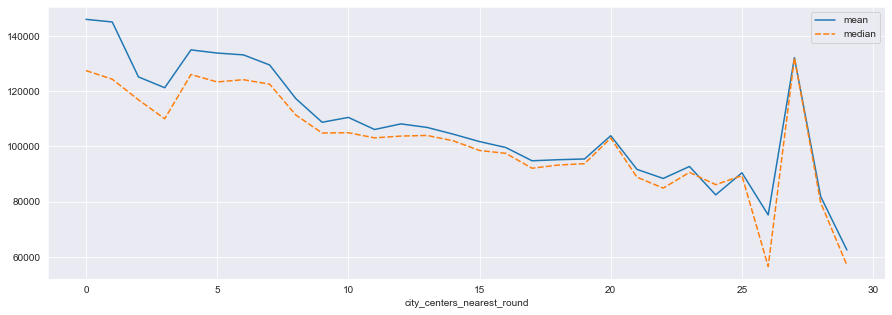

In [70]:
plt.rcParams['figure.figsize']=(15,5)
sns.lineplot(data=estate_city_km)

In [71]:
#выведем на экран таблицу соответствия средней и медианной стоимости квадратного метра
#для каждого километа удаления от центра
estate_city_km

,mean,median
,price_by_meter,price_by_meter
city_centers_nearest_round,,
0,145991.876239,127441.176471
1,145044.878205,124336.412251
2,125147.277886,116852.773395
3,121233.804804,110000.000000
4,134929.209178,126009.693053
5,133791.451885,123333.333333
6,133124.878046,124137.931034
7,129471.560291,122516.556291


По графику зависимости среднего значения и медианы стоимости квадратного метра от расстояния до центра города видно, что цена держится приблизительно на одном уровне до расстояния около 7 км. от центра города, после чего начинает снижаться. Можем наблюдать "проседание" цены от 1 до 4 километров (более выраженное для среднего значения, чем для медианы), небольшие пики на 10 и 20 км., а потом резкий скачок вверх на 27.5 километрах (это может быть либо искажение в данных, либо территория с новой дорогой недвижимостью (элитные частные дома).

В центре города по медиане цена за квадратный метр держится около отметки в 120 тыс. руб., за границей центра в течение 2 км. снижается до 105 тыс., и затем продолжает плавное снижение до 100 тыс. на 15 км. и 90 тыс. на 25 км.

Собственно центром города можно считать площадь с радиусом в 7 километров.

### <a id="center_analis">4.6. Анализ сегмента квартир в центре города</a>

In [72]:
#получим срез с данными по объявлениям из центра города
estate_city_center = estate_clean.query(
    'city_centers_nearest <= 7000 and locality_name == "Санкт-Петербург"')

In [73]:
#получим математическое описание среза данных
estate_city_center.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_area_index,living_area_index,price_by_meter,day_of_week,month,year
count,2529.000000,2.529000e+03,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,1651.000000,2529.000000,1842.000000,2166.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000
mean,9.892448,9.166801e+06,70.000720,2.376829,2.948260,6.856860,40.791211,3.924476,12.263061,0.293792,24465.249901,4405.289838,0.999605,483.748031,1.293397,475.817047,233.653740,0.182877,0.575376,132271.665425,2.499407,6.465006,2017.217082
std,5.691181,4.729055e+06,22.568966,0.972299,0.817973,3.637456,16.452260,2.643401,5.915801,0.721152,3902.547260,1521.731681,0.924568,330.059421,1.085779,270.270858,265.568886,0.078726,0.109786,51374.706723,1.718552,3.428817,1.091506
min,0.000000,1.900000e+06,12.000000,0.000000,2.400000,2.000000,2.000000,1.000000,2.000000,0.000000,15359.000000,208.000000,0.000000,9.000000,0.000000,22.000000,3.000000,0.054348,0.038462,26250.000000,0.000000,1.000000,2014.000000
25%,6.000000,6.215000e+06,51.300000,2.000000,2.700000,5.000000,28.500000,2.000000,8.500000,0.000000,21679.000000,3478.000000,0.000000,287.500000,0.000000,243.000000,59.000000,0.130435,0.516800,100000.000000,1.000000,3.000000,2017.000000
50%,9.000000,8.000000e+06,69.500000,2.000000,2.800000,5.000000,39.500000,3.000000,11.000000,0.000000,24079.000000,4647.000000,1.000000,441.000000,1.000000,466.500000,126.000000,0.171053,0.578125,121428.571429,2.000000,6.000000,2017.000000
75%,14.000000,1.065000e+07,87.000000,3.000000,3.100000,8.000000,52.600000,5.000000,14.600000,0.000000,26737.000000,5515.000000,2.000000,608.500000,2.000000,674.750000,318.750000,0.209677,0.650092,149206.349206,4.000000,10.000000,2018.000000
max,35.000000,3.600000e+07,115.000000,6.000000,32.000000,25.000000,101.000000,23.000000,53.000000,5.000000,34033.000000,6998.000000,3.000000,2295.000000,3.000000,1199.000000,1572.000000,0.625000,0.983447,848484.848485,6.000000,12.000000,2019.000000


Для сегмента квартир в центре города характерны показатели:

    • средняя цена - 9.34 млн. руб. (и 8 млн. по медиане);
    • общая площадь - 70.06 кв. м. (69.5 кв. м.);
    • количество комнат - 2;
    • высота потолков - 2.95 м. (2.8 м.);
    • количество этажей - 7 (5).   

В то время как для всей выборки характерны значения:

    • средняя цена - 6.07 млн. руб. (и 5.1 млн. по медиане);
    • общая площадь - 56.4 кв. м. (52.0 кв. м.);
    • количество комнат - 2;
    • высота потолков - 2.65 - 2.7 м.;
    • количество этажей - от 9 до 11. 

Таким образом можно сделать вывод, что жилье в центре дороже, площадь квартир больше (при том, что количество комнат не отличается от значений для всей выборки), потолки выше, а количество этажей в зданиях меньше.
Результаты сравнения центра города со всей выборкой в целом действительно согласуются с реальностью.

In [74]:
estate_city_center_corr = estate_city_center[['last_price', 'price_by_meter', 'total_area', 'rooms', 'city_centers_nearest']].copy()
print('Корреляционная матрица для центра города')
display(estate_city_center_corr.corr())
print()
print('Корреляционная матрица для всего объема данных')
display(estate_corr.corr()) #отобразим корреляцию для всего объема данных для сравнения

Корреляционная матрица для центра города


,last_price,price_by_meter,total_area,rooms,city_centers_nearest
last_price,1.000000,0.705222,0.593127,0.262276,-0.059993
price_by_meter,0.705222,1.000000,-0.079645,-0.265781,-0.003922
total_area,0.593127,-0.079645,1.000000,0.742153,-0.133151
rooms,0.262276,-0.265781,0.742153,1.000000,-0.160713
city_centers_nearest,-0.059993,-0.003922,-0.133151,-0.160713,1.000000



Корреляционная матрица для всего объема данных


,last_price,price_by_meter,total_area,rooms,city_centers_nearest,balcony,ceiling_height,floor,airports_nearest
last_price,1.000000,0.687643,0.742084,0.435248,-0.351062,0.052422,0.122282,0.029422,-0.031402
price_by_meter,0.687643,1.000000,0.081690,-0.153659,-0.393591,0.029421,0.090011,0.099770,-0.033664
total_area,0.742084,0.081690,1.000000,0.783331,-0.185136,0.052987,0.101828,-0.027645,-0.020895
rooms,0.435248,-0.153659,0.783331,1.000000,-0.103947,-0.003068,0.039793,-0.169297,-0.049574
city_centers_nearest,-0.351062,-0.393591,-0.185136,-0.103947,1.000000,0.062996,-0.107773,0.015609,0.197908
balcony,0.052422,0.029421,0.052987,-0.003068,0.062996,1.000000,-0.008666,0.182092,0.048109
ceiling_height,0.122282,0.090011,0.101828,0.039793,-0.107773,-0.008666,1.000000,-0.022919,-0.032095
floor,0.029422,0.099770,-0.027645,-0.169297,0.015609,0.182092,-0.022919,1.000000,0.089798
airports_nearest,-0.031402,-0.033664,-0.020895,-0.049574,0.197908,0.048109,-0.032095,0.089798,1.000000


Как мы видим, в центральном сегменте корреляция между ценой и общей площадью, а также количеством комнат снизилась (с 0.75 и 0.44 до 0.62 и 0.28 соответственно), а отрицательная  корреляция между ценой и расстоянием до центра снизилась с 0.33 до 0.07 (корреляция фактически нулевая, что является хорошим знаком, поскольку мы анализируем данные квартир, которые входят в область "центр", и для них параметр "близость до центра" не должен играть никакой роли).

<div class="alert alert-block alert-info">Построим графики зависимости стоимости квартиры в центре от изучаемых параметров. Наблюдаем прямую зависимость 1:1 на первом графике (для сравнения показателя с самим собой и не может быть иначе), сильную зависимость и кучное распределение для отношения стоимости квартиры к цене за метр, более слабую, но также кучную в начале, и распыляющуюся с увеличением значений зависимость стоимости квартиры от общей площади (однако даже при увеличивающейся распыленности сохраняется четкая линия тренда). А также сложную зависимость стоимости от удаления от центра города с неразличимой корреляцией (показатель корреляции действительно близок к нулевому значению).<div>

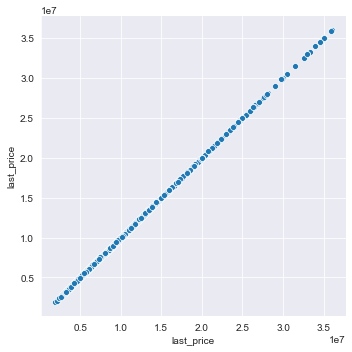

<Figure size 1080x360 with 0 Axes>

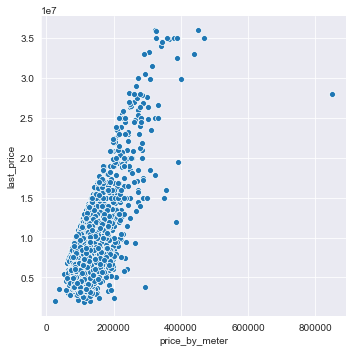

<Figure size 1080x360 with 0 Axes>

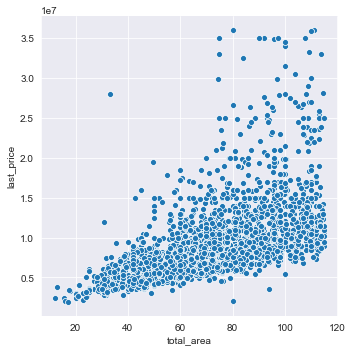

<Figure size 1080x360 with 0 Axes>

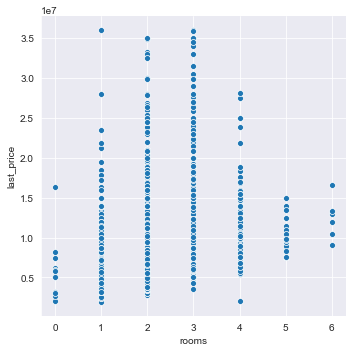

<Figure size 1080x360 with 0 Axes>

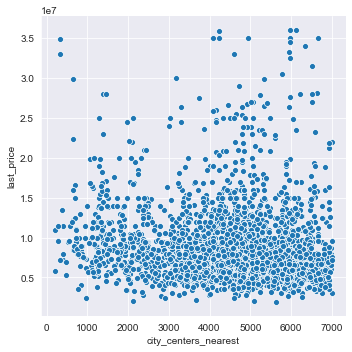

<Figure size 1080x360 with 0 Axes>

In [75]:
for param in estate_city_center_corr:
    sns.relplot(y='last_price', x=param, data=estate_city_center_corr)
    plt.figure()

Проверим влияние даты размещения объявления на финальную стоимость:

In [76]:
estate_center_date = estate_city_center[['last_price', 'day_of_week', 'month', 'year']].copy()
estate_center_date.head()

,last_price,day_of_week,month,year
24,6500000,5,10,2015
61,7990000,3,8,2017
99,9600000,1,9,2017
111,4590000,0,5,2017
114,4000000,3,2,2019


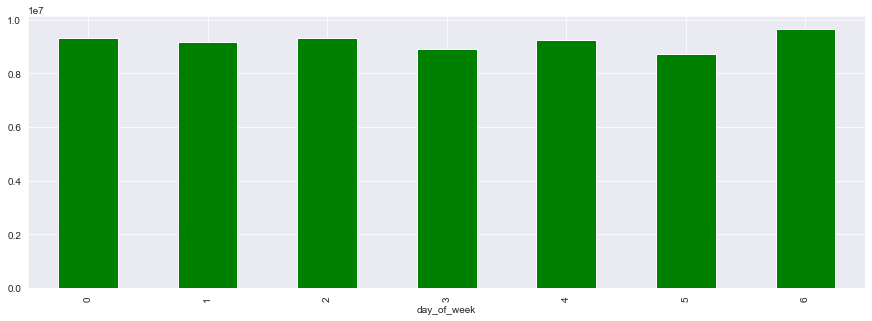

In [77]:
#график распределения цен по дням недели
price_weekday_center = estate_center_date.groupby('day_of_week')['last_price'].mean().plot(kind='bar', 
                                                                             color='green', 
                                                                             grid=True)

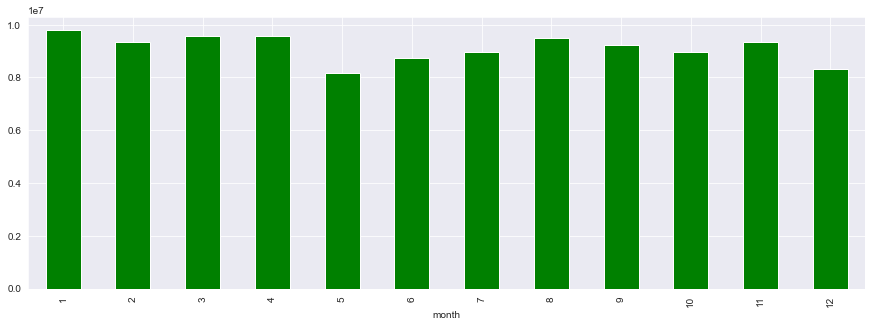

In [78]:
#график распределения цен по месяцам
price_month_center = estate_center_date.groupby('month')['last_price'].mean().plot(kind='bar', 
                                                                     color='green',
                                                                     grid=True)

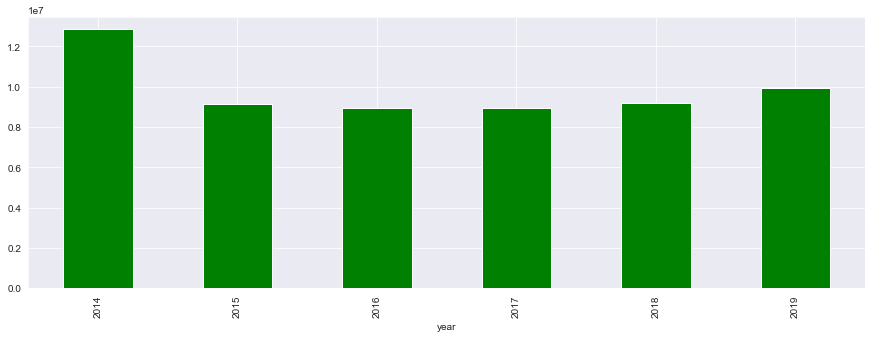

In [79]:
#график распределения цен по годам размещения объявления
price_year_center = estate_center_date.groupby('year')['last_price'].mean().plot(kind='bar',
                                                                    color='green',
                                                                    grid=True)

В плане зависимости цены от дня недели, месяца и года размещения объявления, можем наблюдать для центральной области ту же картину, что и для всей выборки в целом.

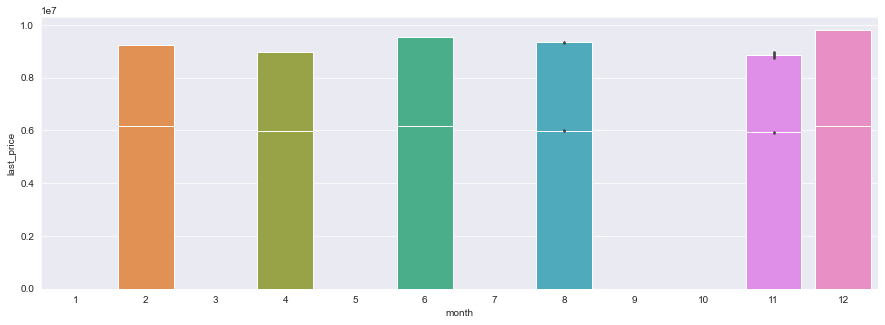

In [80]:
sns.barplot(y=estate_center_date.groupby('month')['last_price'].mean(), x=estate_date['month'])
sns.barplot(y=estate_date.groupby('month')['last_price'].mean(), x=estate_date['month'])
plt.show()

###### [↑ к оглавлению ↑](#to_the_begining)

### <a id="step5">Шаг 5. Общий вывод</a>

По итогам проделанной работы мы можем заключить, что нам удалось вычислить границы центра города, топ-10 локаций с наибольшим количеством объявлений, а также рассчитать средние значения интересующих нас показателей в каждом отдельном случае.

Мы определили, что наибольшее влияние на стоимость жилья предсказуемо оказывает общая площадь жилья.
При этом влияние второстепенных факторов, таких как количество балконов, высота потолков, этаж здания - либо едва заметно, либо вообще неощутимо.
Проанализировать влияние на стоимость того факта, является ли недвижимость апартаментами, у нас не получилось, однако общедоступной информацией является тот факт, что цена на апартаменты может быть ниже стоимости полноценного жилья до 15-30%. 
Количество парков и водоемов в радиусе 3 километров, а также расстояние до ближайших мы не стали анализировать по той причине, что в данных столбцах слишком большое количество пропусков данных, а потенциальная полезность от работы с ними невелика. Несравнимо больше на цену оказывают влияние класс жилья, уровень отделки или ремонта, состояние дома в целом и квартиры в частности.
Для того, чтобы получить достоверную картину о влиянии тех или иных факторов на финальную стоимость жилья, необходимо рассматривать более однородную выборку данных: квартиры в новостройках, предлагающих жилье одного класса. Небольшая квартирка (если такие вообще существуют) на Крестовском острове может стоить на порядок дороже хором в Девяткино. И влияние класса жилья и его статусности перебивает все прочие факторы.

Мы же в нашем исследовании добились поставленной задачи - вычислили средние значения показателей, которые помогут в отслеживании и идентификации мошеннической деятельности с недвижимостью.

###### [↑ к оглавлению ↑](#to_the_begining)

### <a id="check_list">Чек-лист готовности проекта</a>

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод